In [1]:
import os
os.chdir('/home/nick/OSMLoc')
print(os.getcwd())

import os
import sys
from pathlib import Path
from typing import Optional, Tuple, Dict, Any
import numpy as np
import torch
from omegaconf import OmegaConf, DictConfig
from PIL import Image
import matplotlib.pyplot as plt
import argparse

# Add the maploc module to the path
sys.path.append(str(Path.cwd()))

from maploc import logger
from maploc.conf import data as conf_data_dir
from maploc.data import MapillaryDataModule
from maploc.module import GenericModule
from maploc.evaluation.run import evaluate_single_image
from maploc.data.torch import collate, unbatch_to_device

/home/nick/OSMLoc


In [2]:

def setup_configuration(dataset_name: str = "mgl") -> DictConfig:
    """
    Set up the configuration for the OSMLoc model.
    
    Args:
        dataset_name: Name of the dataset to use (mgl, taipei, brisbane, detroit, munich)
    
    Returns:
        Configured DictConfig object
    """
    print(f"Setting up configuration for {dataset_name} dataset...")
    
    # Load the appropriate data configuration
    data_cfg_train = OmegaConf.load(Path(conf_data_dir.__file__).parent / f"mapillary_{dataset_name}.yaml")
    
    # Merge with evaluation-specific configuration
    data_cfg = OmegaConf.merge(
        data_cfg_train,
        {
            "return_gps": True,
            "add_map_mask": True,
            "max_init_error": 32,
            "loading": {"val": {"batch_size": 1, "num_workers": 0}},
        },
    )
    
    # Create the full configuration
    cfg = OmegaConf.create({"data": data_cfg})
    
    return cfg


def load_model(checkpoint_path: str, cfg: DictConfig) -> GenericModule:
    """
    Load the OSMLoc model from a checkpoint.
    
    Args:
        checkpoint_path: Path to the model checkpoint
        cfg: Configuration object
    
    Returns:
        Loaded and configured model
    """
    print(f"Loading model from {checkpoint_path}...")
    
    # Load the model
    model = GenericModule.load_from_checkpoint(
        checkpoint_path, 
        cfg=cfg, 
        find_best=False
    )
    
    logger.info("Evaluating model %s with config %s", checkpoint_path, cfg)
    
    # Set model to evaluation mode
    model = model.eval()
    
    # Move to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        logger.info("Using CUDA for evaluation")
        print("Using CUDA for evaluation")
    else:
        logger.info("Using CPU for evaluation")
        print("Using CPU for evaluation")
    
    return model


def evaluate_single_image_from_dataset(
    model: GenericModule,
    dataset: MapillaryDataModule,
    split: str = "val",
    num_images: int = 1,
    visualize: bool = True
) -> Dict[str, Any]:
    """
    Evaluate single images from the dataset using the OSMLoc model.
    
    Args:
        model: Loaded OSMLoc model
        dataset: Prepared dataset module
        split: Dataset split to use
        num_images: Number of images to evaluate
        visualize: Whether to visualize results
    
    Returns:
        Dictionary containing evaluation results
    """
    print(f"Evaluating {num_images} images from {split} split...")
    
    # Prepare the dataset
    dataset.prepare_data()
    dataset.setup()
    
    # Create a dataloader
    loader = dataset.dataloader(split, shuffle=False, num_workers=0)
    
    # Evaluate using the standard single image evaluation function
    metrics = evaluate_single_image(
        loader, 
        model, 
        num=num_images,
        progress=True,
        callback=None
    )
    
    results = metrics.compute()
    
    if visualize and num_images > 0:
        # Get the first batch to visualize
        batch = next(iter(loader))
        visualize_results(model, batch)
    
    return results


def visualize_results(model: GenericModule, batch: Dict[str, torch.Tensor]):
    """
    Visualize the model's predictions for a given batch.
    
    Args:
        model: OSMLoc model
        batch: Input batch containing image and other data
    """
    print("Generating visualization...")
    
    # Move batch to the appropriate device
    batch = model.transfer_batch_to_device(batch, model.device, 0)
    
    # Get model predictions
    with torch.no_grad():
        pred = model(batch)
    
    # Extract image and predictions
    image = batch["image"][0].cpu().numpy()
    log_probs = pred["log_probs"][0].cpu().numpy()
    uv_max = pred["uv_max"][0].cpu().numpy()
    yaw_max = pred["yaw_max"][0].cpu().numpy()
    
    # Convert image from CHW to HWC format
    if image.shape[0] == 3:  # If it's CHW format
        image = np.transpose(image, (1, 2, 0))
    
    # Normalize image if needed
    if image.max() > 1.0:
        image = image / 255.0
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Show input image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis('off')
    
    # Show prediction heatmap
    plt.subplot(1, 2, 2)
    heatmap = log_probs.max(axis=0)
    plt.imshow(heatmap, cmap='viridis')
    plt.scatter(uv_max[0], uv_max[1], c='red', s=100, marker='x')
    plt.title(f"Prediction Heatmap\nMax at: ({uv_max[0]:.1f}, {uv_max[1]:.1f})\nYaw: {np.degrees(yaw_max[0]):.1f}°")
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print some key metrics
    print(f"Prediction location: ({uv_max[0]:.2f}, {uv_max[1]:.2f})")
    print(f"Prediction yaw: {np.degrees(yaw_max[0]):.2f} degrees")


def validate_inputs(checkpoint_path: str):
    """
    Validate input paths and requirements.
    
    Args:
        checkpoint_path: Path to model checkpoint
    
    Raises:
        FileNotFoundError: If required files don't exist
        ValueError: If inputs are invalid
    """
    # Check checkpoint exists
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    
    # Check if CUDA is available
    if not torch.cuda.is_available():
        print("Warning: CUDA not available, using CPU. This will be slower.")
    
    print("All inputs validated successfully!")


def main():
    """
    Main function to run single image evaluation.
    """

    checkpoint="loca_polar_small.ckpt"
    dataset="mgl"
    split="val"
    num_images=1
    no_visualize=False
    output_dir="./output"
    # Validate inputs
    validate_inputs(checkpoint)
    
    # Setup configuration
    cfg = setup_configuration(dataset)
    
    # Load dataset
    print(f"Loading {dataset} dataset...")
    dataset = MapillaryDataModule(cfg.get("data", {}))
    
    # Load model
    model = load_model(checkpoint, cfg)
    
    # Run evaluation
    print("Running single image evaluation...")
    results = evaluate_single_image_from_dataset(
        model, 
        dataset, 
        split=split,
        num_images=num_images,
        visualize=not no_visualize
    )
    
    # Print results
    print("\n=== Evaluation Results ===")
    for key, value in results.items():
        if hasattr(value, 'compute'):
            computed = value.compute()
            print(f"{key}: {computed}")
        else:
            print(f"{key}: {value}")
    
    print("\nEvaluation completed successfully!")
    



In [3]:
print(f"have cuda {torch.cuda.is_available()}")

have cuda True


Running OSMLoc inference on custom image: ../Data/IMG_20250327_105752435_HDR.jpg
Loading and preprocessing image: ../Data/IMG_20250327_105752435_HDR.jpg


xFormers not available
xFormers not available


Image processed: ../Data/IMG_20250327_105752435_HDR.jpg -> torch.Size([3, 512, 512])
Loading osmloc_small.yaml configuration...
Using direct path: maploc/conf/osmloc_small.yaml
Configuration exists: True
Model configuration loaded:
  latent_dim: 128
  image_encoder.features: 64
  image_encoder.out_channels: [48, 96, 192, 384]
    full_key: model.map_encoder.num_classes
    object_type=dict
  Using default values for interpolation references
  map_encoder.num_classes: {'areas': 7, 'ways': 10, 'nodes': 33}
  pixel_per_meter: 2
  map_encoder.output_dim: 8
Updated depth_anything checkpoint: checkpoints/depth_anything/depth_anything_vits14.pth -> maploc/models/depth_anything/ckpt/depth_anything_vits14.pth
Loading model from loca_polar_small.ckpt...
Model configuration being used:
  model.latent_dim: 128
  model.matching_dim: 8
  image_encoder.encoder: vits
  image_encoder.features: 64
  image_encoder.out_channels: [48, 96, 192, 384]
  map_encoder.num_classes: {'areas': 7, 'ways': 10, 'nodes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


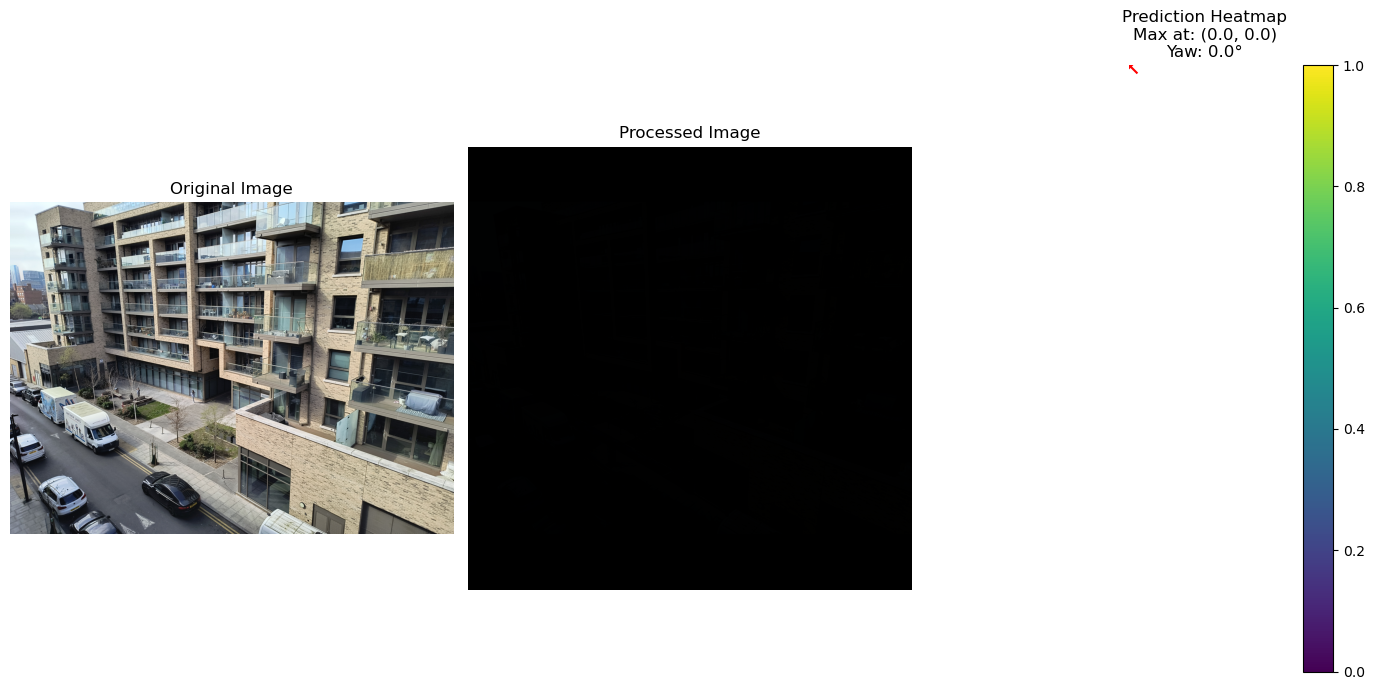

Results saved to: ../Data/IMG_20250327_105752435_HDR_osmloc_results.json


In [4]:
from custom_image_inference import run_custom_image_inference
import json

checkpoint="loca_polar_small.ckpt"
dataset="mgl"
split="val"
num_images=1
no_visualize=False
image_path="../Data/IMG_20250327_105752435_HDR.jpg"

results = run_custom_image_inference(
    image_path,
    checkpoint_path=checkpoint,
    dataset_name=dataset,
    visualize=not no_visualize
)

# Save results
output_file = f"{os.path.splitext(image_path)[0]}_osmloc_results.json"
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {output_file}")

